In [ ]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
import numpy as np
%matplotlib inline
from tensorflow.keras.applications import VGG19

In [ ]:
model = VGG19(weights='imagenet', include_top=False)
model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224,3))
    img = image.img_to_array(img)
    img = preprocess_input(img)  # Important: VGG preprocessing
    return img

content_image = load_and_preprocess_image("/content/drive/MyDrive/WhatsApp Image 2025-07-01 at 16.09.01.jpeg")/255
style_image = load_and_preprocess_image("/content/drive/MyDrive/images.jpeg")/255


In [ ]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

In [ ]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [ ]:
def create_model(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    # Use vgg.input (a single tensor) instead of [vgg.input] (a list of tensors)
    model = tf.keras.Model(vgg.input, outputs)
    return model


content_model = create_model(content_layers)
style_model = create_model(style_layers)

In [ ]:
content_targets = content_model(np.array([content_image]))
style_targets = style_model(np.array([style_image]))

In [ ]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [ ]:
def content_loss(generated_output, content_output):
    return tf.reduce_mean(tf.square(generated_output - content_output))

In [ ]:
def style_loss(generated_output, style_output):
    gen_gram = gram_matrix(generated_output)
    style_gram = gram_matrix(style_output)
    return tf.reduce_mean(tf.square(gen_gram - style_gram))


In [ ]:
def compute_loss(generated_image):
    # Get model outputs
    gen_content_output = content_model(generated_image)
    gen_style_output = style_model(generated_image)

    # Compute losses
    c_loss = content_loss(gen_content_output[-1], content_targets[-1])
    s_loss = 0
    for gen_style, style_target in zip(gen_style_output, style_targets):
        s_loss += style_loss(gen_style, style_target)
    s_loss /= len(style_layers)

    # Weighted sum
    total_loss = c_loss +  s_loss
    #total_loss = c_loss + s_loss
    return total_loss, c_loss, s_loss

In [ ]:
def deprocess_image(processed_img):
    x = processed_img.copy()
    x = np.clip(x, 0, 255)
    return x.astype('uint8')

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=0.02)

# Training loop
for epoch in range(1000):
    with tf.GradientTape() as tape:
        total_loss, c_loss, s_loss = compute_loss(tf.expand_dims(generated_image, 0))

    gradients = tape.gradient(total_loss, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])

    # Clip pixel values
    generated_image.assign(tf.clip_by_value(generated_image, 0.0, 255.0))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Total Loss: {total_loss.numpy()}, "
              f"Content Loss: {c_loss.numpy()}, Style Loss: {s_loss.numpy()}")

Epoch 0, Total Loss: 3774.119140625, Content Loss: 0.0, Style Loss: 3774.119140625
Epoch 100, Total Loss: 31.984935760498047, Content Loss: 1.311747670173645, Style Loss: 30.673187255859375
Epoch 200, Total Loss: 17.52181625366211, Content Loss: 1.3232756853103638, Style Loss: 16.19853973388672
Epoch 300, Total Loss: 12.921276092529297, Content Loss: 1.3372797966003418, Style Loss: 11.583996772766113
Epoch 400, Total Loss: 10.649127006530762, Content Loss: 1.3372604846954346, Style Loss: 9.311866760253906
Epoch 500, Total Loss: 9.283994674682617, Content Loss: 1.3273484706878662, Style Loss: 7.956645965576172
Epoch 600, Total Loss: 8.348200798034668, Content Loss: 1.3170700073242188, Style Loss: 7.031130790710449
Epoch 700, Total Loss: 7.674570560455322, Content Loss: 1.3089443445205688, Style Loss: 6.365626335144043
Epoch 800, Total Loss: 7.149827003479004, Content Loss: 1.2978384494781494, Style Loss: 5.851988792419434
Epoch 900, Total Loss: 6.724954128265381, Content Loss: 1.2841506

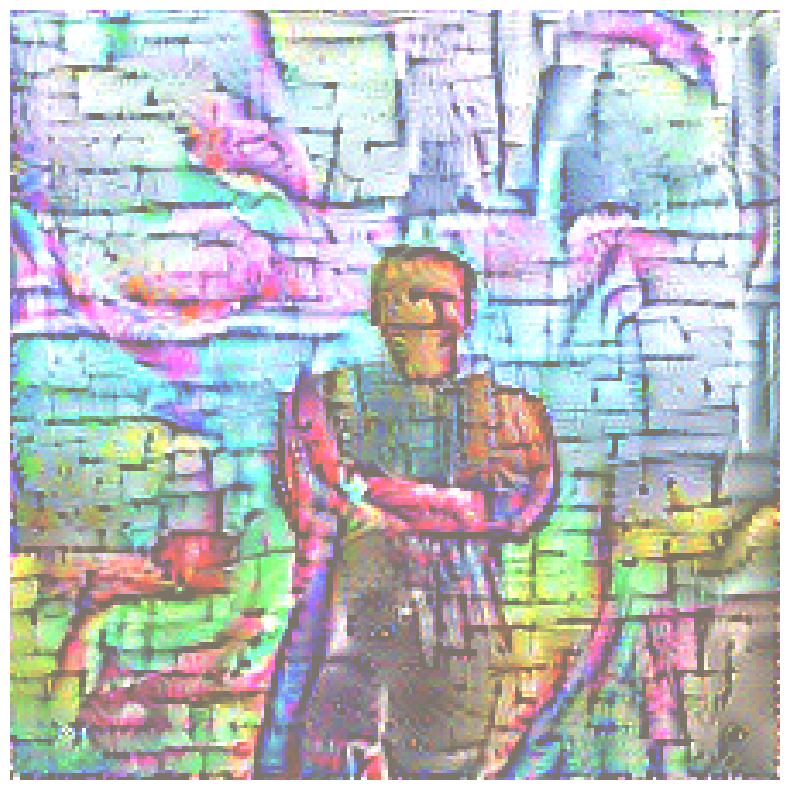

In [ ]:
def deprocess(x):
    x = x.numpy()
    x[..., 0] += 103.939  # Reverse VGG19 preprocessing
    x[..., 1] += 116.779
    x[..., 2] += 123.68
    x = x[..., ::-1]  # BGR to RGB
    return np.clip(x, 0, 255).astype('uint8')

plt.figure(figsize=(10, 10))
plt.imshow(deprocess(generated_image*255))
plt.axis('off')
plt.show()